In [8]:
import os
import numpy as np

import torch
from torchvision import transforms

import backdoor_attack as bd
import net

In [9]:
# result output folder
out = os.path.join('results', 'screening')
os.makedirs(os.path.join(out), exist_ok=True)

# device setup
if torch.cuda.is_available():
    device = torch.device(type='cuda', index=1)
else:
    device = torch.device(type='cpu')

## データセットの準備

In [10]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [11]:
ds_root = os.path.join('.', 'results', 'datasets')
tr = np.load(os.path.join(ds_root, 'poison_training_dataset.npz'))
train_ds = bd.Dataset_from_array(x=tr['x'], t=tr['t'], transform=transform)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=False)

## モデルの準備

In [12]:
backdoor_path = os.path.join('results', 'backdoor_model')
backdoor_model = net.CNV()
dummy_input = torch.Tensor(np.zeros((1, 1, 28, 28)).astype(np.float32))
_ = backdoor_model(dummy_input)
backdoor_model.load_state_dict(torch.load(os.path.join(backdoor_path, 'model.pt')))
backdoor_model = backdoor_model.eval()

In [13]:
distilled_path = os.path.join('results', 'distilled_model')
distilled_model = net.CNV()
dummy_input = torch.Tensor(np.zeros((1, 1, 28, 28)).astype(np.float32))
_ = distilled_model(dummy_input)
distilled_model.load_state_dict(torch.load(os.path.join(distilled_path, 'model.pt')))
distilled_model = distilled_model.eval()

## データセットのスクリーニング

precision    recall  f1-score   support

       False       1.00      1.00      1.00     49652
        True       0.99      0.28      0.44       348

   micro avg       0.99      0.99      0.99     50000
   macro avg       0.99      0.64      0.72     50000
weighted avg       0.99      0.99      0.99     50000



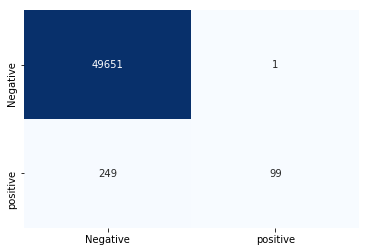

In [14]:
screening = bd.distillation.Dataset_screening(train_dl, backdoor_model, distilled_model, device=device)
screening.run()
negative_dataset = screening.negative_dataset
positive_dataset = screening.positive_dataset
np.savez(os.path.join(out, 'screening_negative_dataset.npz'), x=negative_dataset['x'], t=negative_dataset['t'])

confmat, report = screening.eval(tr['t_correct'])
print(report)
bd.plot_util.plot_confusion_matrix(
    confmat,
    cmap='Blues',
    fmt='d',
    annot=True,
    cbar=False,
    xticklabels=['Negative', 'positive'],
    yticklabels=['Negative', 'positive']
)

np.savez(
    os.path.join(out, 'result.npz'),
    negative_dataset = negative_dataset,
    positive_dataset = positive_dataset,
    confmat = confmat,
    report = report
)